# Structured Bayesian Optimisation with Pyro

Goal: apply Structured Bayesian Optimisation (BO) strategy to minimize Branin-Hoo function with pyro.

Based on: 
- branin_hoo_pyro_semiparam_brooks.ipynb
- branin_hoo_pyro_bo.ipynb

In [1]:
import math
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import torch
import torch.autograd as autograd
import torch.optim as optim
from torch.distributions import constraints, transform_to

import pyro
import pyro.contrib.gp as gp

assert pyro.__version__.startswith('0.4')

import torch.nn as nn
import pyro.distributions as dist

pyro.enable_validation(True)
pyro.set_rng_seed(1)

# Objective function

In [2]:
# Branin Hoo constants
const_a = 1.0
const_b = 5.1 / (4.0 * math.pow(math.pi, 2))
const_c = 5.0 / math.pi
const_r = 6.0
const_s = 10
const_t = 1.0 / (8.0 * math.pi)

const_x1_min = -5
const_x1_max = 10

const_x2_min = 0
const_x2_max = 15

def branin_hoo_first_term(X):
    return const_s * (1.0 - const_t) * torch.cos(X[0]) + const_s

def branin_hoo(X):
    return branin_hoo_first_term(X) + \
        const_a * torch.pow(X[1] - const_b * torch.pow(X[0], 2) + const_c * X[0] - const_r, 2)

# Checking LMs
assert np.allclose(
        branin_hoo(torch.stack((
            torch.tensor([-math.pi, math.pi, 9.42478]), 
            torch.tensor([12.275, 2.275, 2.475])))).numpy(),
        np.array([0.397887, 0.397887, 0.397887], dtype=np.float32), rtol=1e-6)

# Visualisation of the objective function 
Impossible in a real-world setting

In [3]:
steps = 1000
strides = 200

X1 = torch.linspace(const_x1_min, const_x1_max, steps)
X2 = torch.linspace(const_x2_min, const_x2_max, steps)

X1_mesh, X2_mesh = torch.meshgrid(X1, X2)
Z_mesh = branin_hoo(torch.stack((X1_mesh, X2_mesh)))

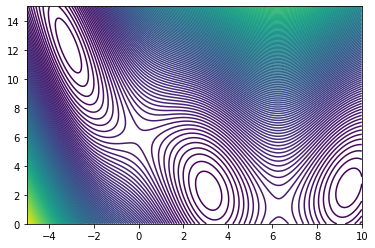

In [4]:
plt.contour(X1_mesh, X2_mesh, Z_mesh, strides)

# Initial (train) data

Generating random (5) training points

In [5]:
train_cnt = 5

X1_train = torch.tensor([x for x in np.random.uniform(low=const_x1_min, high=const_x1_max, size=train_cnt)])
X2_train = torch.tensor([x for x in np.random.uniform(low=const_x2_min, high=const_x2_max, size=train_cnt)])
X_train = torch.stack((X1_train, X2_train))

Y_train = branin_hoo(X_train)

# Parametric model in pyro

In [6]:
def parametric_fn(X, alpha, beta, gamma):
    x1 = X[...,0]
    x2 = X[...,1]
    return alpha * torch.cos(x1) + beta*torch.pow(x1, 4) + torch.pow(x2, 2) + gamma

# Semi parametric model as implemented by Brooks

In [24]:
pyro.clear_param_store()

class SemiParametricModel(nn.Module):

    def __init__(self, X, y):
        super().__init__()
        
        # Store data
        D = X.shape[-1]
        self.X = X
        self.y = y
        
        # Define parameters for parametric model
        # TODO: I couldn't figure out how to do this using `pyro.param`, so instead
        #       I am using `nn.Parameter`. This is annoying, because now constraints
        #       need to be handled manually, using the properties below
        self._mu_a = nn.Parameter(torch.zeros(1))
        self._mu_b = nn.Parameter(torch.zeros(1))
        self._mu_c = nn.Parameter(torch.zeros(1))
        self._sd_a = nn.Parameter(torch.zeros(1))
        self._sd_b = nn.Parameter(torch.zeros(1))
        self._sd_c = nn.Parameter(torch.zeros(1))
        
        self._mu_transform = transform_to(constraints.interval(0, 20))
        self._sd_transform = transform_to(constraints.positive)

        # Define GP regressor (leave the data arguments empty for now)
        self.gp = gp.models.GPRegression(torch.empty((0, D)), torch.empty((0,)),
                                         kernel=gp.kernels.Matern52(input_dim=D, lengthscale=torch.ones(D)))

        # Set priors for GP (these are the values used in the semiparametric BOAT model, which assumes noiseless GP)
        self.gp.kernel.set_prior("lengthscale", dist.LogNormal(0.0, 15.0))
        self.gp.kernel.set_prior("variance", dist.Uniform(0.0, 20.0))
        self.gp.set_prior("noise", dist.Uniform(0.0, 1.0))

        # Set guides for GP
        self.gp.kernel.autoguide("lengthscale", dist.Normal)
        self.gp.kernel.autoguide("variance", dist.Normal)
        self.gp.autoguide("noise", dist.Normal)
    
    @property
    def mu_a(self): return self._mu_transform(self._mu_a)

    @property
    def mu_b(self): return self._mu_transform(self._mu_b)

    @property
    def mu_c(self): return self._mu_transform(self._mu_c)

    @property
    def sd_a(self): return self._sd_transform(self._sd_a)

    @property
    def sd_b(self): return self._sd_transform(self._sd_b)
    
    @property
    def sd_c(self): return self._sd_transform(self._sd_c)
    
    def guide(self):
        self.gp.guide()
        alpha = pyro.sample('alpha', dist.Normal(self.mu_a, self.sd_a))
        beta = pyro.sample('beta', dist.Normal(self.mu_b, self.sd_b))
        gamma = pyro.sample('gamma', dist.Normal(self.mu_c, self.sd_c))
        return alpha, beta, gamma

    def model(self):
        alpha = pyro.sample('alpha', dist.Uniform(0, 20))
        beta = pyro.sample('beta', dist.Uniform(0, 20))
        gamma = pyro.sample('gamma', dist.Uniform(0, 20))
        g = parametric_fn(self.X, alpha, beta, gamma)
        residual = self.y - g
        # update the GP to now model the residual from the parametric model
        self.gp.set_data(self.X, residual)
        # call GP model function to actually make the observation
        self.gp.model()
        
    def forward(self, X):
        g = parametric_fn(X, *self.guide())
        mu, sigma = self.gp(X)
        return g + mu, sigma

semi_parametric = SemiParametricModel(X_train.T, Y_train)


# Constructing SBO strategy

### Defining acquisition function

In [20]:
def acquisition_func(x):
    kappa = 2.0
    
    mu, variance = semi_parametric(x)
        
    sigma = variance.sqrt()
    
    return mu - kappa * sigma

tensor([10.], grad_fn=<AddBackward0>)

### Function to find minimizing points for an acquisition function

In [21]:
def find_a_candidate(x_init):
    
    # Creating constrains
    constraint_x1 = constraints.interval(const_x1_min, const_x1_max)
    constraint_x2 = constraints.interval(const_x2_min, const_x2_max)
    
    # transform x_init to an unconstrained domain as we use an unconstrained optimizer
    unconstrained_x1_init = transform_to(constraint_x1).inv(x_init[:, 0])
    unconstrained_x2_init = transform_to(constraint_x2).inv(x_init[:, 1])
    x_uncon_init = torch.stack((unconstrained_x1_init, unconstrained_x2_init), dim=1)
    
    x_uncon = x_uncon_init.clone().detach().requires_grad_(True)
    
    # unconstrained minimiser
    minimizer = optim.LBFGS([x_uncon])

    def closure():
        minimizer.zero_grad()
                
        x1_tmp = transform_to(constraint_x1)(x_uncon[:, 0])
        x2_tmp = transform_to(constraint_x2)(x_uncon[:, 1])
        x = torch.stack((x1_tmp, x2_tmp), dim=1)
        
        y = acquisition_func(x)
        
        autograd.backward(x_uncon, autograd.grad(y, x_uncon))
                
        return y
    
    minimizer.step(closure)
   
    # after finding a candidate in the unconstrained domain,
    # convert it back to original domain.
    x1_tmp = transform_to(constraint_x1)(x_uncon[:, 0])
    x2_tmp = transform_to(constraint_x2)(x_uncon[:, 1])
    
    x = torch.stack((x1_tmp, x2_tmp), dim=1)
    
    return x.detach()

### A single step of SBO

In [22]:
def next_x(num_candidates=5):
    
    candidates = []
    values = []
    
    # take the last point as the first attempt
    x_init = semi_parametric.X[-1:]
    
    for i in range(num_candidates):
        
        x = find_a_candidate(x_init)
        y = acquisition_func(x)
    
        candidates.append(x)
        values.append(y)
        
        # a new random attempt initial point
        x_init = torch.stack((
                x[:,0].new_empty(1).uniform_(const_x1_min, const_x1_max),
                x[:,1].new_empty(1).uniform_(const_x2_min, const_x2_max)), dim=1)
        
    argmin = torch.min(torch.cat(values), dim=0)[1].item()
    
    return candidates[argmin]

### Updating posterior

# The SBO Algorithm

In [23]:
sbo_steps = 10

for i in range(sbo_steps):
    xmin = next_x()
    #update_posterior(xmin)

RuntimeError: invalid argument 13: ldc should be at least max(1, m=0), but have 0 at ../aten/src/TH/generic/THBlas.cpp:367